Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Primary dataset loaded successfully!
Enron Spam dataset loaded successfully!

Primary Dataset Overview:
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

Enron Spam Dataset Overview:
   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   
2           2  calpine daily gas nomination   
3           3               

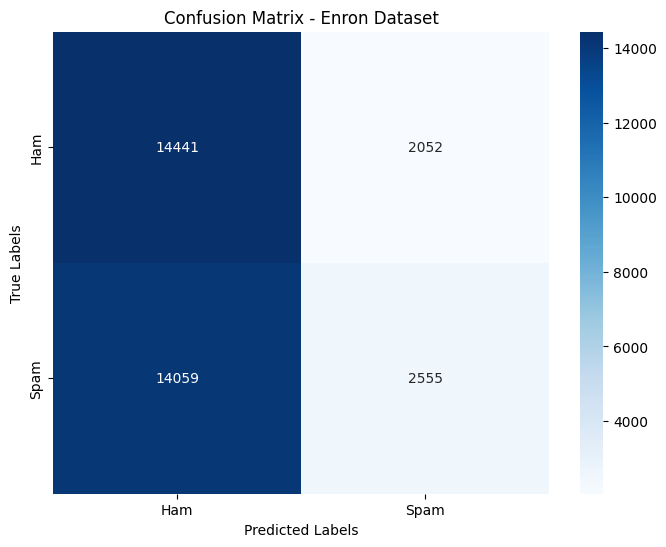


Comparison of Model Performance:
                 Model  Dataset  Accuracy
0  Logistic Regression  Primary  0.959641
1  Logistic Regression    Enron  0.507446
2        Decision Tree  Primary  0.962332
3        Decision Tree    Enron  0.513366


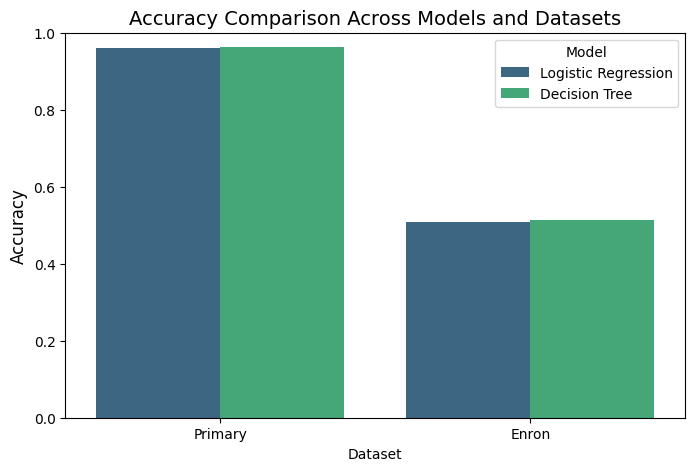


By evaluating on both datasets and comparing Logistic Regression and Decision Tree models, we assessed robustness, generalizability, and identified areas for improvement.


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ensure necessary libraries are installed
!pip install nltk

# Import libraries and download NLTK data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the punkt_tab resource

# Load primary dataset (SMSSpamCollection)
primary_dataset_path = '/content/drive/MyDrive/dataset/SMSSpamCollection'
try:
    primary_data = pd.read_csv(primary_dataset_path, sep='\t', header=None, names=['label', 'text'])
    print("Primary dataset loaded successfully!")
except FileNotFoundError:
    print("Error: The primary dataset was not found. Please check the path.")
    raise

# Load Enron Spam Dataset
enron_dataset_path = '/content/drive/MyDrive/dataset/enron_spam_data.csv'
try:
    enron_data = pd.read_csv(enron_dataset_path)
    print("Enron Spam dataset loaded successfully!")
except FileNotFoundError:
    print("Error: The Enron Spam dataset was not found. Please check the path.")
    raise

# Display basic information about datasets
print("\nPrimary Dataset Overview:")
print(primary_data.head())
print(primary_data.info())

print("\nEnron Spam Dataset Overview:")
print(enron_data.head())
print(enron_data.info())

# Check class distributions
print("\nPrimary Dataset Label Distribution:")
print(primary_data['label'].value_counts())

print("\nEnron Spam Dataset Label Distribution:")
print(enron_data['Spam/Ham'].value_counts())

# Define preprocessing function
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)  # Join tokens back into a single string

# Process primary dataset
primary_data['processed_text'] = primary_data['text'].apply(preprocess_text)
primary_data['label'] = primary_data['label'].map({'spam': 1, 'ham': 0})  # Map labels to binary values

# Process Enron dataset
enron_data['processed_text'] = enron_data['Message'].astype(str).apply(preprocess_text)
enron_data['label'] = enron_data['Spam/Ham'].map({'spam': 1, 'ham': 0})

# Drop rows with missing values
primary_data.dropna(inplace=True)
enron_data.dropna(inplace=True)

# TF-IDF feature extraction
vectorizer = TfidfVectorizer(max_features=5000)

# Transform primary dataset
X_primary = vectorizer.fit_transform(primary_data['processed_text'])
y_primary = primary_data['label']

# Transform Enron dataset
X_enron = vectorizer.transform(enron_data['processed_text'])
y_enron = enron_data['label']

# Split primary dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_primary, y_primary, test_size=0.2, random_state=42)

# Train and evaluate Logistic Regression as a baseline
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Evaluate Logistic Regression on primary dataset
y_test_pred_log = log_reg.predict(X_test)
log_primary_accuracy = accuracy_score(y_test, y_test_pred_log)
print("\nLogistic Regression - Primary Dataset Accuracy:", log_primary_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_log))

# Evaluate Logistic Regression on Enron dataset
y_enron_pred_log = log_reg.predict(X_enron)
log_enron_accuracy = accuracy_score(y_enron, y_enron_pred_log)
print("\nLogistic Regression - Enron Dataset Accuracy:", log_enron_accuracy)
print("\nClassification Report:\n", classification_report(y_enron, y_enron_pred_log))

# Train Decision Tree with hyperparameter tuning
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}
clf = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
clf.fit(X_train, y_train)

print("\nBest Decision Tree Parameters:", clf.best_params_)

# Evaluate Decision Tree on primary dataset
y_test_pred_tree = clf.predict(X_test)
tree_primary_accuracy = accuracy_score(y_test, y_test_pred_tree)
print("\nDecision Tree - Primary Dataset Accuracy:", tree_primary_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_tree))

# Evaluate Decision Tree on Enron dataset
y_enron_pred_tree = clf.predict(X_enron)
tree_enron_accuracy = accuracy_score(y_enron, y_enron_pred_tree)
print("\nDecision Tree - Enron Dataset Accuracy:", tree_enron_accuracy)
print("\nClassification Report:\n", classification_report(y_enron, y_enron_pred_tree))

# Cross-dataset evaluation: Train on Enron, Test on Primary
X_enron_train, X_enron_test, y_enron_train, y_enron_test = train_test_split(X_enron, y_enron, test_size=0.2, random_state=42)
clf.fit(X_enron_train, y_enron_train)

# Evaluate on primary dataset
y_primary_pred_cross = clf.predict(X_primary)
cross_dataset_accuracy = accuracy_score(y_primary, y_primary_pred_cross)
print("\nCross-Dataset Evaluation Accuracy (Train on Enron, Test on Primary):", cross_dataset_accuracy)

# Error analysis
conf_matrix = confusion_matrix(y_enron, y_enron_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix - Enron Dataset")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

# Compare results
results = {
    "Model": ["Logistic Regression", "Logistic Regression", "Decision Tree", "Decision Tree"],
    "Dataset": ["Primary", "Enron", "Primary", "Enron"],
    "Accuracy": [log_primary_accuracy, log_enron_accuracy, tree_primary_accuracy, tree_enron_accuracy]
}
results_df = pd.DataFrame(results)
print("\nComparison of Model Performance:")
print(results_df)

# Plot results
plt.figure(figsize=(8, 5))
sns.barplot(x="Dataset", y="Accuracy", hue="Model", data=results_df, palette="viridis")
plt.title("Accuracy Comparison Across Models and Datasets", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)
plt.show()

# Conclusion
print("\nBy evaluating on both datasets and comparing Logistic Regression and Decision Tree models, we assessed robustness, generalizability, and identified areas for improvement.")
